In [22]:
%matplotlib notebook 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc
import numpy as np
from tqdm import tqdm
import matplotlib.animation as anim
from mpl_toolkits.mplot3d import Axes3D

In [23]:
k = 5. 
l = 3. 
m = 2. 
g = 9.8 
r0 = 15.
theta_0 = np.pi/8
r_punto0 = 0.
theta_punto0 = 0.

In [24]:
def a_r(r, theta, theta_punto):
    return k*(l - r)/m + g*np.cos(theta) + r*(theta_punto)**2

def a_theta(r, r_punto, theta, theta_punto):
    return -g*np.sin(theta)/r - 2*r_punto*theta_punto/r

In [25]:
t = np.linspace(0,30,2001)
h = 0.015 

In [27]:
r_vec_0 = [[r0,theta_0],[r_punto0, theta_punto0]]


In [39]:
def GetEuler(a_theta, a_r, r0, t, Npoints):
    r_vec = np.zeros((len(t),2))
    r = np.array(r0[0])
    r_vec[0] =r
    
    vel_vec = np.zeros((len(t),2))
    v = np.array(r0[1])
    vel_vec[0] = v
    
    a = np.array([[a_r(r[0],r[1],v[1])],[a_theta(r[0], v[0], r[1], v[1])]])
    
    dt = t[1] - t[0]
    for i in range(1, Npoints):
        
        r += v*dt
        v[0] += a[0]*dt
        v[1] += a[1]*dt
        vel_vec[i] = v
        r_vec[i] = r
        #print(r)
        
        
        a = np.array([[a_r(r[0],r[1],v[1])],[a_theta(r[0], v[0], r[1], v[1])]])
    
    return r_vec, vel_vec

In [40]:
r_vec, vel_vec = GetEuler(a_theta, a_r, r_vec_0, t, 3)

In [41]:
def GetBeeman(a_t, a_r,r0,t):
    
    Npoints = 2
    
    h = (t[1] - t[0])
    
    # Predictor
    r_vec, v_vec = GetEuler(a_t,a_r,r0,t,Npoints)
    # Corrector
    rc_vec = r_vec.copy()
    velc_vec = vel_vec.copy
    
    for i in range(Npoints,len(t)):
        
        a_n = np.array([a_r(r_vec[i-1][0], r_vec[i-1][1], v_vec[i-1][1]),a_theta(r_vec[i-1][0], v_vec[i-1][0], r_vec[i-1][1], v_vec[i-1][1])])
        a_n2 = np.array([a_r(r_vec[i-2][0], r_vec[i-2][1], v_vec[i-2][1]),a_theta(r_vec[i-2][0], v_vec[i-2][0], r_vec[i-2][1], v_vec[i-2][1])])
        
        r_vec[i] = r_vec[i-1] + h*v_vec[i-1] + (4*a_n - a_n2)*(h**2)/6
        
        #Predictor
        
        v_vec[i] = v_vec[i-1] + (3*a_n - a_n2)*h/2
        
        #Corrector
        
        a_nc = np.array([a_r(r_vec[i][0], r_vec[i][1], v_vec[i][1]),a_theta(r_vec[i][0], v_vec[i][0], r_vec[i][1], v_vec[i][1])])
        
        v_vec[i] = v_vec[i-1] + (5*a_nc + 8*a_n - a_n2)*h/12
    
    r, theta = r_vec[:,0], r_vec[:,1]
    
    rpunto, thetapunto = v_vec[:,0], v_vec[:,1]
    
    return r, theta, rpunto, thetapunto
    
        
    

In [42]:
r, theta, rpunto, thetapunto = GetBeeman(a_theta, a_r, r_vec_0,t)

In [43]:
Limits = [-20, 20]

In [44]:
def ReduceSize(r, theta, factor):
        
        RrVector = np.array(r[0]) # initial condition
        RThetaVector = np.array(theta[0])
        
        for i in range(1,len(r)):
            if i%factor == 0:
                RrVector = np.vstack([RrVector, r[i]])
                RThetaVector = np.vstack([RThetaVector, theta[i]])
                
        return RrVector, RThetaVector
    

def ReduceTime(t,factor):
        
    Newt = []
    
    for i in range(len(t)):
        if i%factor == 0:
            Newt.append(t[i])
            
    return np.array(Newt)

reduccion = 20
redt = ReduceTime(t, reduccion)
redr, redtheta = ReduceSize(r, theta, reduccion)

x = redr*np.cos(redtheta - np.pi/2)
y = redr*np.sin(redtheta - np.pi/2)

x = x[:, 0]
y = y[:, 0]

<IPython.core.display.Javascript object>


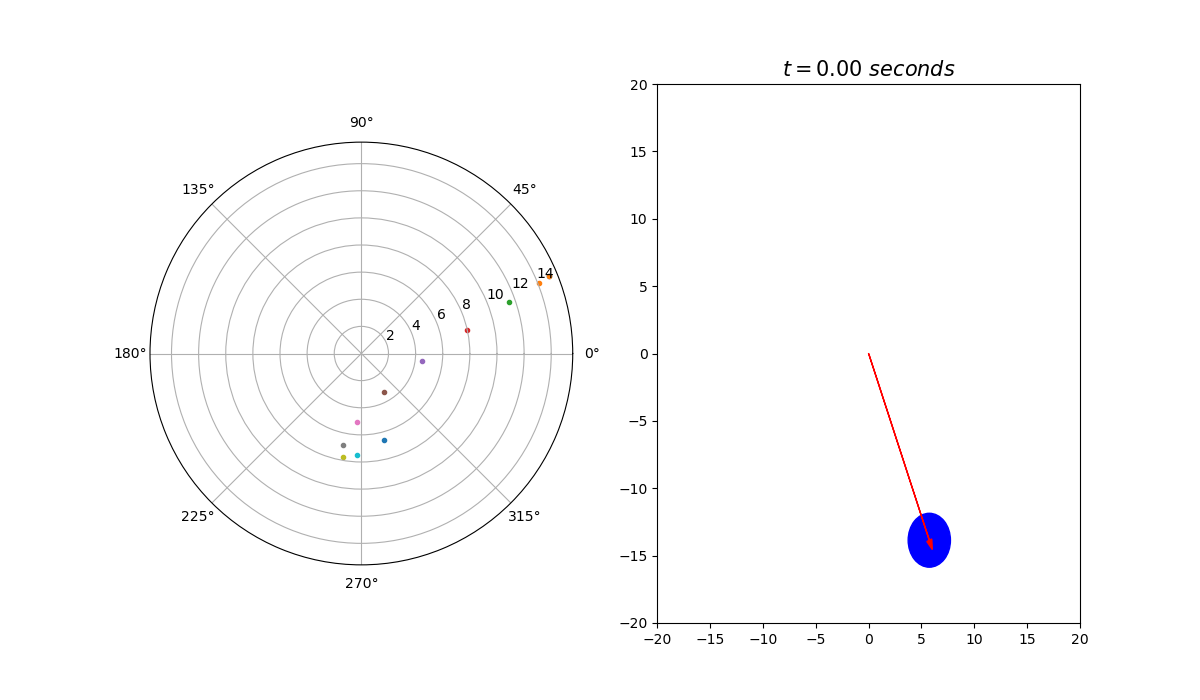

CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x700', '-pix_fmt', 'rgba', '-r', '20', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'artist=Me', '-y', 'parcial_1.mp4']' returned non-zero exit status 255.

In [45]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(1,2,1 ,projection='polar')
ax2 = fig.add_subplot(1,2,2)

def init():
    ax2.set_xlim(Limits[0], Limits[1])
    ax2.set_ylim(Limits[0], Limits[1])

def Update(i):
    
    plot = ax2.clear()
    init()
    plot = ax2.set_title(r'$t=%.2f \ seconds$' %(redt[i]), fontsize=15)
    
    pelota = plt.Circle( (x[i],y[i]), 2, color='b', fill=True)
    plot = ax2.add_patch(pelota)
    
    plot = ax2.arrow(0,0,x[i],y[i],color='r',head_width=0.5)
    
    ax1.scatter(redtheta[i], redr[i], marker='.')

    return plot


Animation = anim.FuncAnimation(fig,Update,frames=len(redt),init_func=init)

Writer = anim.writers['ffmpeg']
writer_ = Writer(fps=20, metadata=dict(artist='Me'))
Animation.save('parcial_1.mp4', writer=writer_)